In [3]:
import sys

import os
os.getcwd()
sys.path.append("..")
os.chdir("..")  
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.express as px
import plotly.graph_objects as go
from statsmodels.tsa.seasonal import seasonal_decompose

In [4]:
sns.set(style="whitegrid")
plt.rcParams["figure.figsize"] = (14, 6)

In [5]:
import warnings
 

# Display settings
pd.set_option('display.max_columns', 100)
warnings.filterwarnings('ignore')
sns.set(style="whitegrid")

In [6]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
sns.set(style="whitegrid", palette="pastel", font_scale=1.1)
from src.load_data import load_data


2025-05-30 19:11:42.507 | INFO     | src.config:<module>:11 - PROJ_ROOT path is: D:\ds-toolkit\DS-toolkit


In [7]:
base_path = "D:/ds-toolkit/DS-toolkit/data/raw/"
train_path = base_path + "train.csv"
stores_path = base_path + "stores.csv"
oil_path = base_path + "oil.csv"
holidays_path = base_path + "holidays_events.csv"
test_path = base_path + "test.csv"
transaction_path = base_path + 'transactions.csv'
sample_path = base_path +"sample_submission.csv"

In [8]:
train = pd.read_csv(train_path, parse_dates=['date'])
stores = pd.read_csv(stores_path)
oil = pd.read_csv(oil_path, parse_dates=['date'])
holidays = pd.read_csv(holidays_path, parse_dates=['date'])
test = pd.read_csv(test_path , parse_dates=['date'])
transaction = pd.read_csv(transaction_path, parse_dates=['date'])
sample_submission = pd.read_csv(sample_path)



In [9]:
train.isnull().sum()

id             0
date           0
store_nbr      0
family         0
sales          0
onpromotion    0
dtype: int64

Check Shapes and Columns

In [10]:

print("Test:", test.shape, test.columns.tolist())
print("Stores:", stores.shape, stores.columns.tolist())
print("Oil:", oil.shape, oil.columns.tolist())
print("Holidays:", holidays.shape, holidays.columns.tolist())
print("Sample Submission:", sample_submission.shape)


Test: (28512, 5) ['id', 'date', 'store_nbr', 'family', 'onpromotion']
Stores: (54, 5) ['store_nbr', 'city', 'state', 'type', 'cluster']
Oil: (1218, 2) ['date', 'dcoilwtico']
Holidays: (350, 6) ['date', 'type', 'locale', 'locale_name', 'description', 'transferred']
Sample Submission: (28512, 2)


In [11]:

print("Train")
print(train.head())

print("\nTest")
print(test.head())

print("\nStores")
print(stores.head())

print("\nOil")
print(oil.head())

print("\nHolidays")
print(holidays.head())

print("\nSample Submission")
print(sample_submission.head())


Train
   id       date  store_nbr      family  sales  onpromotion
0   0 2013-01-01          1  AUTOMOTIVE    0.0            0
1   1 2013-01-01          1   BABY CARE    0.0            0
2   2 2013-01-01          1      BEAUTY    0.0            0
3   3 2013-01-01          1   BEVERAGES    0.0            0
4   4 2013-01-01          1       BOOKS    0.0            0

Test
        id       date  store_nbr      family  onpromotion
0  3000888 2017-08-16          1  AUTOMOTIVE            0
1  3000889 2017-08-16          1   BABY CARE            0
2  3000890 2017-08-16          1      BEAUTY            2
3  3000891 2017-08-16          1   BEVERAGES           20
4  3000892 2017-08-16          1       BOOKS            0

Stores
   store_nbr           city                           state type  cluster
0          1          Quito                       Pichincha    D       13
1          2          Quito                       Pichincha    D       13
2          3          Quito                       

missing values

In [12]:
 
print("Missing Values:")
for df_name, df in zip(['train', 'test', 'stores', 'oil', 'holidays','transaction'], [train, test, stores, oil, holidays,transaction]):
    print(f"{df_name}:")
    print(df.isnull().mean().round(4) * 100)
    print()


Missing Values:
train:
id             0.0
date           0.0
store_nbr      0.0
family         0.0
sales          0.0
onpromotion    0.0
dtype: float64

test:
id             0.0
date           0.0
store_nbr      0.0
family         0.0
onpromotion    0.0
dtype: float64

stores:
store_nbr    0.0
city         0.0
state        0.0
type         0.0
cluster      0.0
dtype: float64

oil:
date          0.00
dcoilwtico    3.53
dtype: float64

holidays:
date           0.0
type           0.0
locale         0.0
locale_name    0.0
description    0.0
transferred    0.0
dtype: float64

transaction:
date            0.0
store_nbr       0.0
transactions    0.0
dtype: float64



Data Ranges 

In [13]:
print("Train Date Range:", train['date'].min(), "to", train['date'].max())
print("Test Date Range:", test['date'].min(), "to", test['date'].max())
print("Oil Date Range:", oil['date'].min(), "to", oil['date'].max())
print("Holidays Date Range:", holidays['date'].min(), "to", holidays['date'].max())


Train Date Range: 2013-01-01 00:00:00 to 2017-08-15 00:00:00
Test Date Range: 2017-08-16 00:00:00 to 2017-08-31 00:00:00
Oil Date Range: 2013-01-01 00:00:00 to 2017-08-31 00:00:00
Holidays Date Range: 2012-03-02 00:00:00 to 2017-12-26 00:00:00


EDAs

In [14]:
#train = train.merge(stores, on='store_nbr', how='left')

In [15]:
fractional_sales = train[train['sales'] % 1 != 0]
print(f"Fractional sales count: {len(fractional_sales)}")
fractional_sales.head()

Fractional sales count: 462113


,id,date,store_nbr,family,sales,onpromotion
566,566,2013-01-01,25,BREAD/BAKERY,180.589000,0
570,570,2013-01-01,25,DELI,71.090000,0
572,572,2013-01-01,25,FROZEN FOODS,29.654999,0
585,585,2013-01-01,25,MEATS,110.801000,0
589,589,2013-01-01,25,POULTRY,42.637000,0


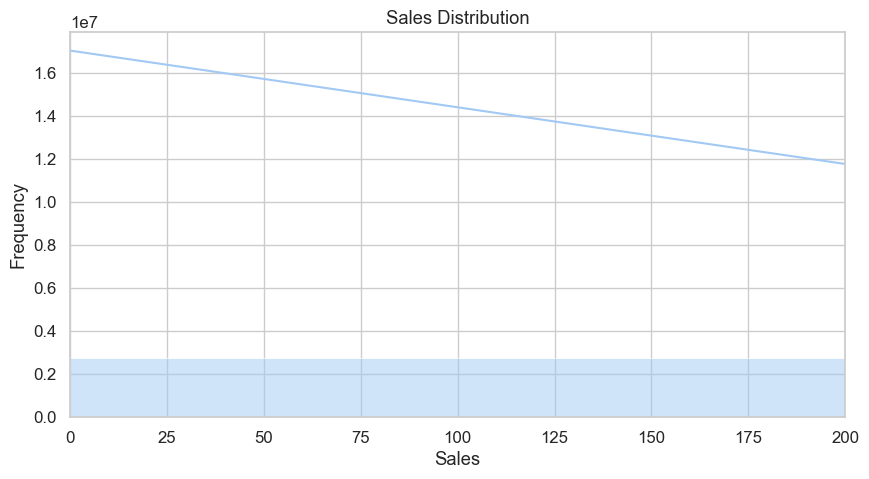

In [16]:

# Histogram of sales
plt.figure(figsize=(10, 5))
sns.histplot(train['sales'], bins=100, kde=True)
plt.title('Sales Distribution')
plt.xlabel('Sales')
plt.ylabel('Frequency')
plt.xlim(0, 200)  
plt.show()

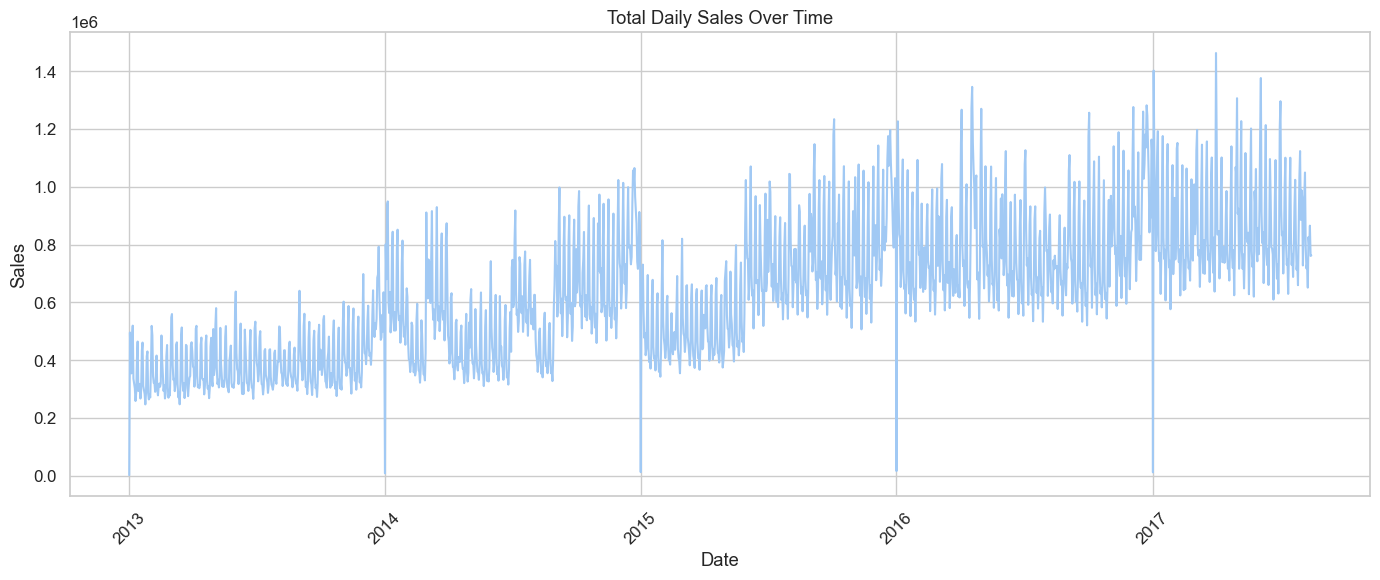

In [17]:
# Daily total sales trend
daily_sales = train.groupby('date')['sales'].sum().reset_index()
plt.figure()
sns.lineplot(data=daily_sales, x='date', y='sales')
plt.title("Total Daily Sales Over Time")
plt.xlabel("Date")
plt.ylabel("Sales")
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

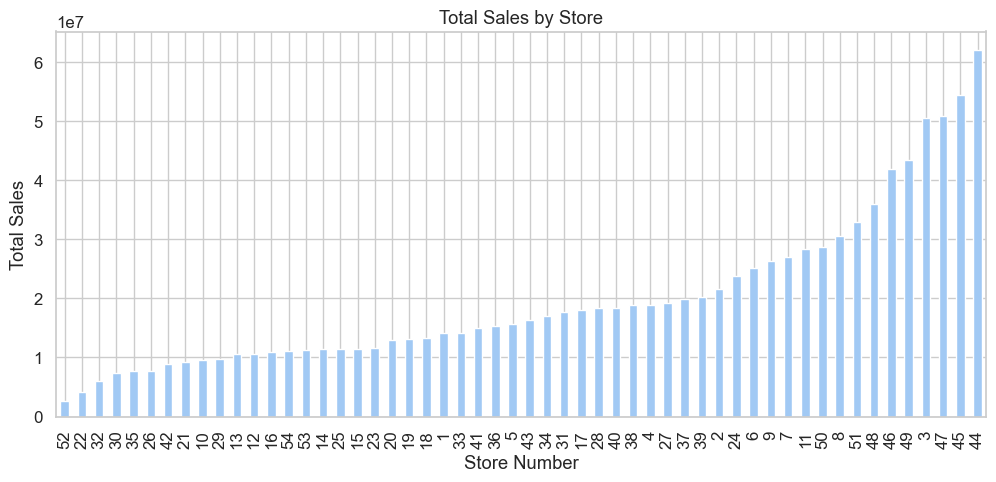

In [18]:
#Compare performance of each store.
plt.figure(figsize=(12, 5))
train.groupby('store_nbr')['sales'].sum().sort_values().plot(kind='bar')
plt.title('Total Sales by Store')
plt.ylabel('Total Sales')
plt.xlabel('Store Number')
plt.show()


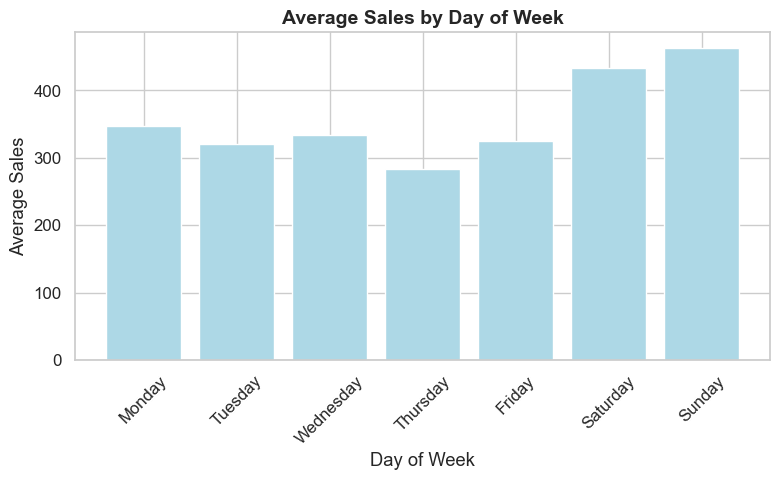

In [19]:
import pandas as pd
import matplotlib.pyplot as plt

# Convert date to datetime if needed and extract day name
train['date'] = pd.to_datetime(train['date'])  # Skip if already datetime
train['day_name'] = train['date'].dt.day_name()

# Define weekday order
days = ['Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday', 'Saturday', 'Sunday']

# Group by day and reindex to keep weekday order
dow_sales = train.groupby('day_name')['sales'].mean().reindex(days)

# Plot
plt.figure(figsize=(8, 5))
plt.bar(range(len(dow_sales)), dow_sales.values, color='lightblue')
plt.title('Average Sales by Day of Week', fontsize=14, fontweight='bold')
plt.xlabel('Day of Week')
plt.ylabel('Average Sales')
plt.xticks(ticks=range(len(days)), labels=days, rotation=45)
plt.tight_layout()
plt.show()


Sunday shopping is big in Ecuador, possibly due to:

People having more free time on weekends.

Weekly or bi-weekly restocking behavior.

Some stores may offer special promotions on Sundays.

Families shop together, which can boost basket size.

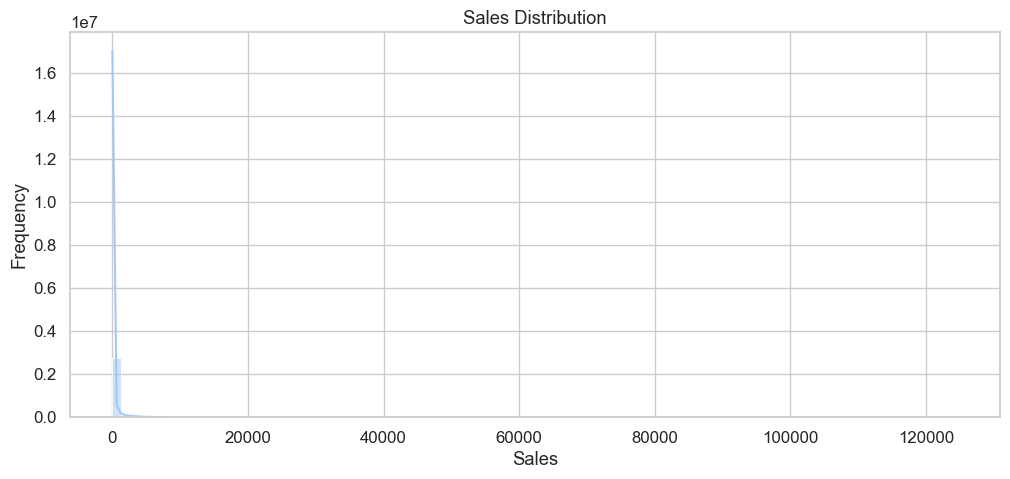

In [20]:
# Sales distribution
plt.figure(figsize=(12,5))
sns.histplot(train['sales'], bins=100, kde=True)
plt.title("Sales Distribution")
plt.xlabel("Sales")
plt.ylabel("Frequency")
plt.show()

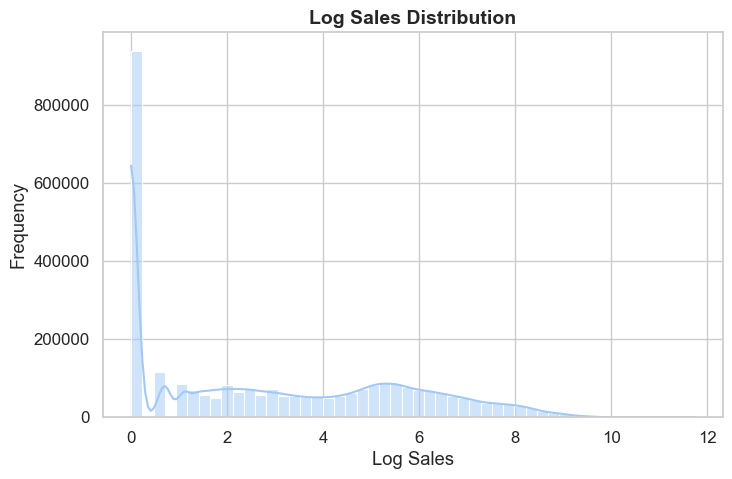

In [21]:
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

train['log_sales'] = np.log1p(train['sales'])

plt.figure(figsize=(8, 5))
sns.histplot(train['log_sales'], bins=50, kde=True)
plt.title('Log Sales Distribution', fontsize=14, fontweight='bold')
plt.xlabel('Log Sales')
plt.ylabel('Frequency')
plt.show()


In [22]:
train = train.merge(stores, on='store_nbr', how='left')
if 'type' not in train.columns:
    print("Merging stores.csv to access store 'type' column.")
    stores = pd.read_csv(stores_path)  # adjust path if needed
    train = train.merge(stores, on='store_nbr', how='left')


<Figure size 1200x500 with 0 Axes>

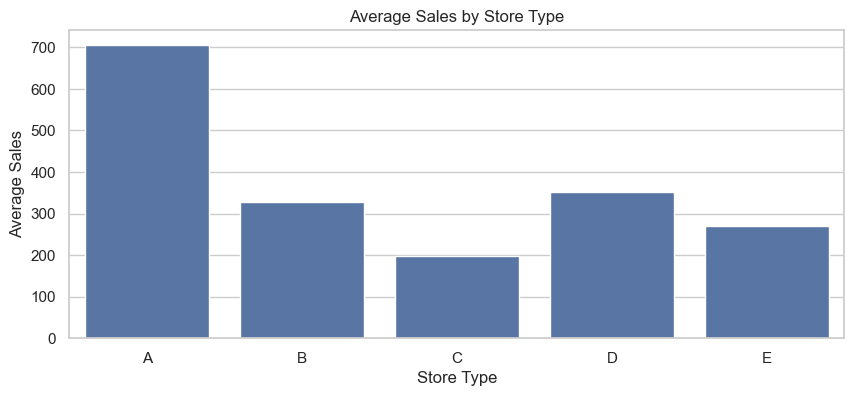

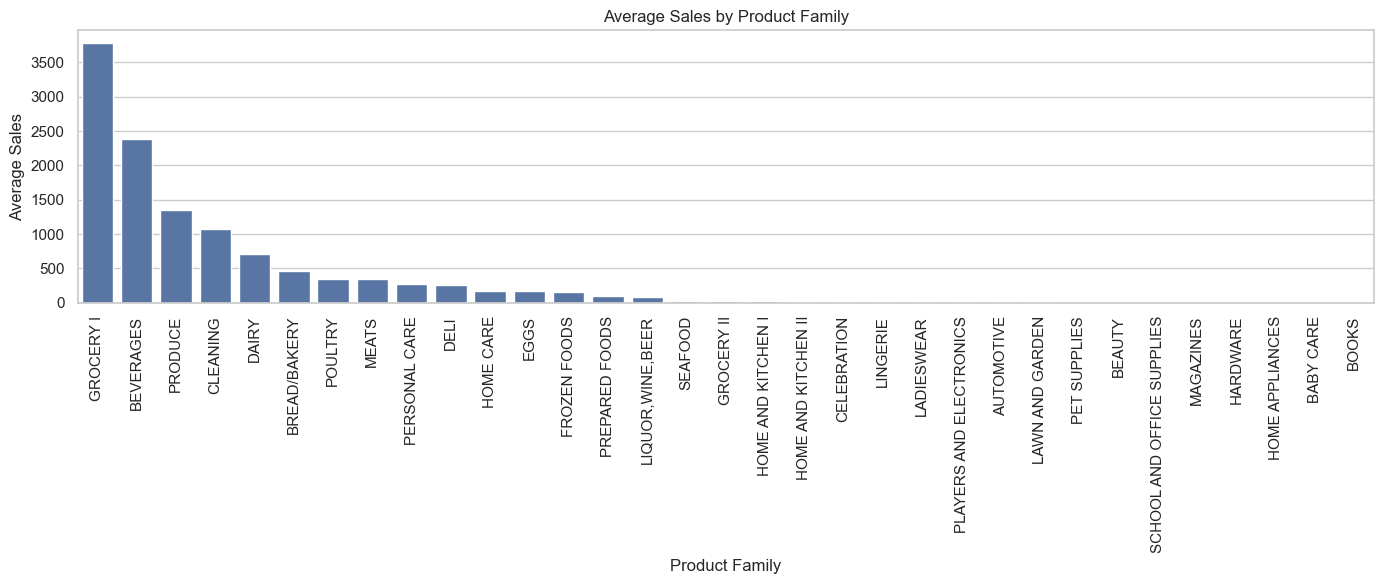

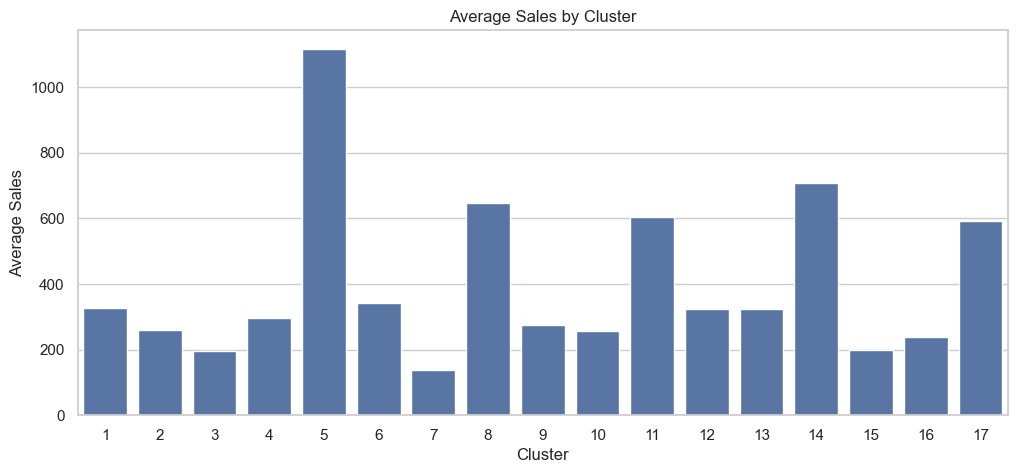

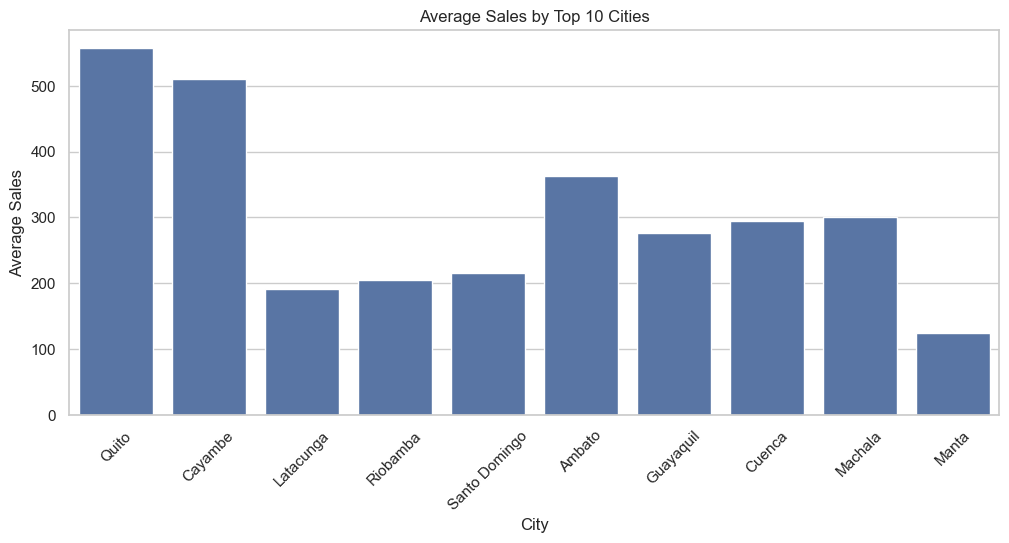

In [23]:
import matplotlib.pyplot as plt
import seaborn as sns


# Set style
sns.set(style="whitegrid")
plt.figure(figsize=(12, 5))

# Sales by store type
plt.figure(figsize=(10, 4))
sns.barplot(data=train, x='type', y='sales', estimator='mean', ci=None, order=sorted(train['type'].unique()))
plt.title('Average Sales by Store Type')
plt.ylabel('Average Sales')
plt.xlabel('Store Type')
plt.show()

# Sales by product family
plt.figure(figsize=(14, 6))
family_sales = train.groupby('family')['sales'].mean().sort_values(ascending=False)
sns.barplot(x=family_sales.index, y=family_sales.values)
plt.xticks(rotation=90)
plt.title('Average Sales by Product Family')
plt.ylabel('Average Sales')
plt.xlabel('Product Family')
plt.tight_layout()
plt.show()

# Sales by cluster
plt.figure(figsize=(12, 5))
sns.barplot(data=train, x='cluster', y='sales', estimator='mean', ci=None)
plt.title('Average Sales by Cluster')
plt.xlabel('Cluster')
plt.ylabel('Average Sales')
plt.show()

# Sales by city (optional - limited number for clarity)
top_cities = train['city'].value_counts().head(10).index
plt.figure(figsize=(12, 5))
sns.barplot(data=train[train['city'].isin(top_cities)], x='city', y='sales', estimator='mean', ci=None)
plt.title('Average Sales by Top 10 Cities')
plt.xlabel('City')
plt.ylabel('Average Sales')
plt.xticks(rotation=45)
plt.show()


Oil Price Over Time

In [24]:
train = train.merge(oil, on='date', how='left')
train['dcoilwtico'] = train['dcoilwtico'].fillna(method='ffill')


In [25]:

daily_sales_oil = train.groupby('date')[['sales', 'dcoilwtico']].sum().reset_index()


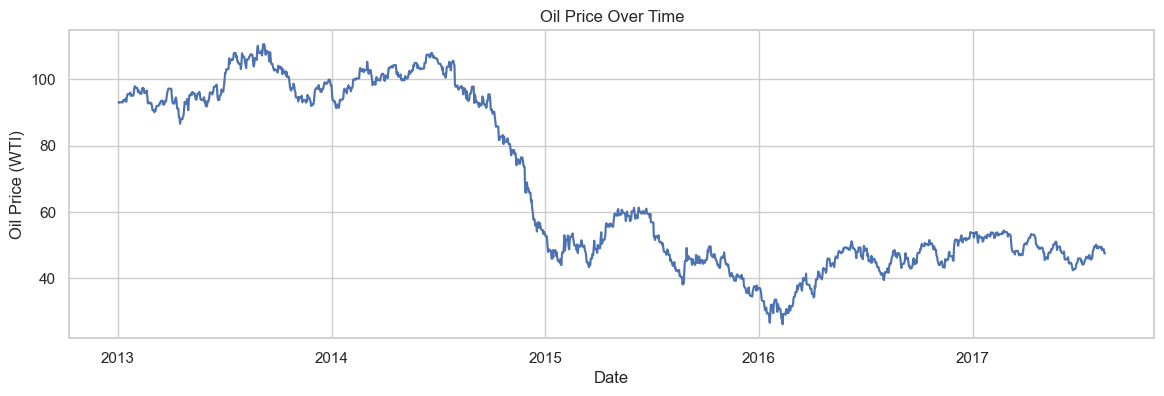

In [26]:
plt.figure(figsize=(14, 4))
sns.lineplot(data=train, x='date', y='dcoilwtico')
plt.title('Oil Price Over Time')
plt.ylabel('Oil Price (WTI)')
plt.xlabel('Date')
plt.show()



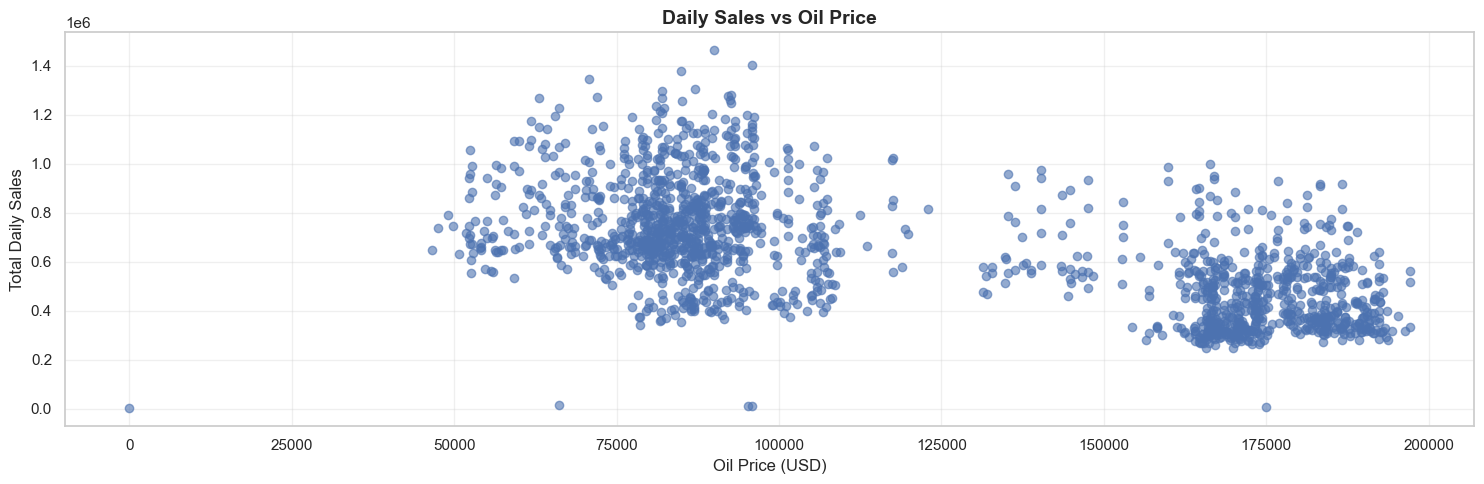

In [27]:
import matplotlib.pyplot as plt
fig, axes = plt.subplots(figsize=(15, 5))

plt.scatter(daily_sales_oil['dcoilwtico'], daily_sales_oil['sales'], alpha=0.6)
plt.title('Daily Sales vs Oil Price', fontsize=14, fontweight='bold')
plt.xlabel('Oil Price (USD)')
plt.ylabel('Total Daily Sales')
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()


In [28]:
correlation = daily_sales_oil['sales'].corr(daily_sales_oil['dcoilwtico'])
print(f"\nCorrelation between oil price and daily sales: {correlation:.4f}")



Correlation between oil price and daily sales: -0.6199


Transaction

 Plot Total Transactions Over Time

In [30]:
# Group Daily Store Sales
# Merge with Transactions

daily_store_sales = train.groupby(['date', 'store_nbr'])['sales'].sum().reset_index()
sales_transactions = daily_store_sales.merge(transaction, on=['date', 'store_nbr'], how='inner')

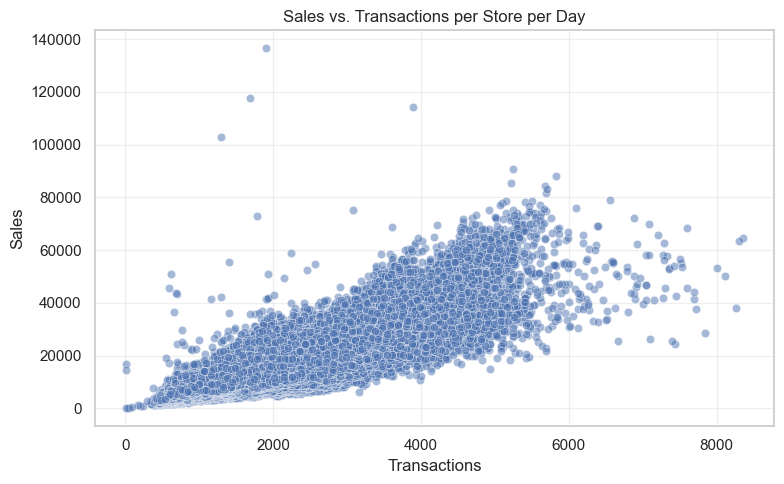

In [31]:
plt.figure(figsize=(8, 5))
sns.scatterplot(data=sales_transactions, x='transactions', y='sales', alpha=0.5)
plt.title('Sales vs. Transactions per Store per Day')
plt.xlabel('Transactions')
plt.ylabel('Sales')
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()


In [32]:
corr = sales_transactions['sales'].corr(sales_transactions['transactions'])
print(f"Correlation between sales and transactions: {corr:.4f}")


Correlation between sales and transactions: 0.8374


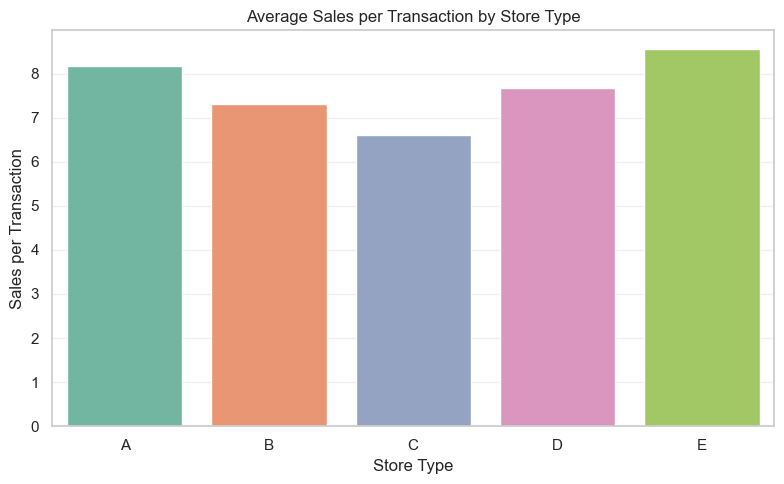

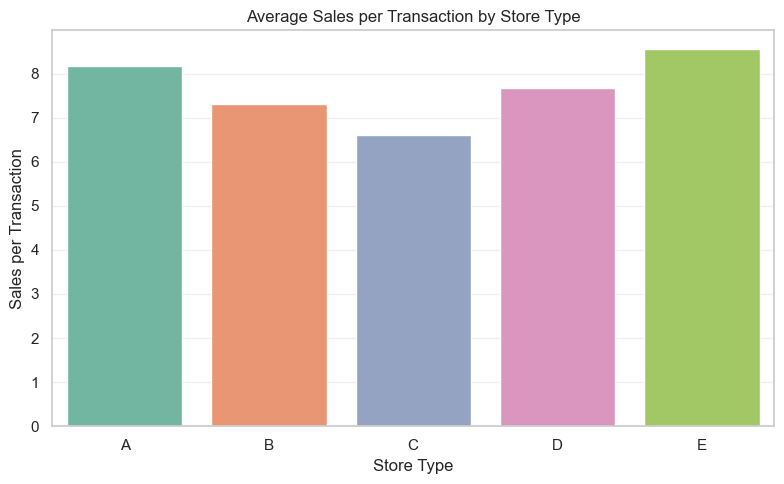

In [33]:
# Merge store info if not done yet
sales_transactions = sales_transactions.merge(stores, on='store_nbr', how='left')

# Calculate sales per transaction
sales_transactions['sales_per_transaction'] = sales_transactions['sales'] / sales_transactions['transactions']

# Group by store type (or any other category)
avg_sales_per_txn = sales_transactions.groupby('type')['sales_per_transaction'].mean().reset_index()

# Bar plot
plt.figure(figsize=(8, 5))
sns.barplot(data=avg_sales_per_txn, x='type', y='sales_per_transaction', palette='Set2')
plt.title('Average Sales per Transaction by Store Type')
plt.ylabel('Sales per Transaction')
plt.xlabel('Store Type')
plt.grid(axis='y', alpha=0.3)
plt.tight_layout()
plt.show()

sales_transactions['sales_per_transaction'] = sales_transactions['sales'] / sales_transactions['transactions']

# Group by store type (or any other category)
avg_sales_per_txn = sales_transactions.groupby('type')['sales_per_transaction'].mean().reset_index()

# Bar plot
plt.figure(figsize=(8, 5))
sns.barplot(data=avg_sales_per_txn, x='type', y='sales_per_transaction', palette='Set2')
plt.title('Average Sales per Transaction by Store Type')
plt.ylabel('Sales per Transaction')
plt.xlabel('Store Type')
plt.grid(axis='y', alpha=0.3)
plt.tight_layout()
plt.show()
